### O que terei que fazer:
-Para cada .csv, em ordem alfabética:
    - Ajustar nome das colunas
    - Filtrar colunas pelo local a ser estudado, por 'Gasolina' e por unidade de medida
    - Pegar somente colunas necessárias e comuns
    - Ajustar tipos das colunas (ponto e float no preço de venda e parse_dates na data de coletas)
    - Concatenar ao dataframe final

- Retirar a média do valor da venda para cada data de coleta
- Completar demais datas (valor anterior ou média móvel??)
- Extrair variável resposta

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [3]:
files = [f for f in glob.glob('./data_vr/*.csv')]
files.sort()

In [4]:
files

['./data_vr/2018-07-gasolina-etanol.csv',
 './data_vr/2018-08-gasolina-etanol.csv',
 './data_vr/2018-09-gasolina-etanol.csv',
 './data_vr/2018-10-gasolina-etanol.csv',
 './data_vr/2018-11-gasolina-etanol.csv',
 './data_vr/2018-12-gasolina-etanol.csv',
 './data_vr/2019-01-gasolina-etanol.csv',
 './data_vr/2019-02-gasolina-etanol.csv',
 './data_vr/2019-03-gasolina-etanol.csv',
 './data_vr/2019-04-gasolina-etanol.csv',
 './data_vr/2019-05-gasolina-etanol.csv']

In [5]:

colunas_desejadas = ['Região-Sigla', 'Estado-Sigla', 'Município','Produto',
       'DatadaColeta', 'ValordeVenda','UnidadedeMedida','Bandeira']

In [6]:
##Concatenando arquivos

df_final=pd.DataFrame()
for file in files:
    df_aux = pd.read_csv(file,sep='\t',encoding='utf-16le')
    df_aux.columns = df_aux.columns.map(lambda x: x.replace(' ','')) #alterando nomes para garantir integridade entre arquivos
    df_aux = df_aux.loc[(df_aux['Produto']=='GASOLINA')&(df_aux['Município']=='BRASILIA')] #somente produtos de gasolina
    
    df_final = pd.concat([df_final,df_aux[colunas_desejadas]],axis=0) #concatenando apenas colunas desejadas
    
    #break

In [7]:
df_final.shape

(2253, 8)

In [8]:
df_final.isnull().sum()

Região-Sigla       0
Estado-Sigla       0
Município          0
Produto            0
DatadaColeta       0
ValordeVenda       0
UnidadedeMedida    0
Bandeira           0
dtype: int64

In [9]:
df_final.to_csv('./data_tf/data_bsb_raw.csv')

In [10]:
df_final= pd.read_csv('./data_tf/data_bsb_raw.csv')

In [11]:
df_final['ValordeVenda']=df_final['ValordeVenda'].apply(lambda x: x.replace(',','.')).astype(np.float64)

In [12]:
df_final['DatadaColeta'] =pd.to_datetime(df_final['DatadaColeta'],format='%d/%m/%Y')

In [13]:
df_final.head()

Unnamed: 0 Região-Sigla Estado-Sigla Município   Produto DatadaColeta  \
0       22282           CO           DF  BRASILIA  GASOLINA   2018-07-03   
1       22283           CO           DF  BRASILIA  GASOLINA   2018-07-03   
2       22284           CO           DF  BRASILIA  GASOLINA   2018-07-03   
3       22285           CO           DF  BRASILIA  GASOLINA   2018-07-03   
4       22286           CO           DF  BRASILIA  GASOLINA   2018-07-03   

   ValordeVenda UnidadedeMedida                      Bandeira  
0         4.399      R$ / litro                        RAIZEN  
1         4.499      R$ / litro  PETROBRAS DISTRIBUIDORA S.A.  
2         4.399      R$ / litro  PETROBRAS DISTRIBUIDORA S.A.  
3         4.699      R$ / litro                      IPIRANGA  
4         4.599      R$ / litro                        RAIZEN

In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 9 columns):
Unnamed: 0         2253 non-null int64
Região-Sigla       2253 non-null object
Estado-Sigla       2253 non-null object
Município          2253 non-null object
Produto            2253 non-null object
DatadaColeta       2253 non-null datetime64[ns]
ValordeVenda       2253 non-null float64
UnidadedeMedida    2253 non-null object
Bandeira           2253 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 158.5+ KB


In [15]:
#df_final['DatadaColeta'].value_counts()

#Na primeira versão não descartarei nenhum dia, mesmo com poucos dados

In [16]:
df_data_preco = pd.DataFrame(df_final.groupby('DatadaColeta')['ValordeVenda'].mean()).reset_index()

In [17]:
df_data_preco.head()

DatadaColeta  ValordeVenda
0   2018-07-03      4.499000
1   2018-07-04      4.580244
2   2018-07-10      4.594191
3   2018-07-16      4.589043
4   2018-07-18      4.690000

In [18]:
from datetime import timedelta
def fill_dates(data,date_col='DatadaColeta',value_col='ValordeVenda'):
    min_date = data[date_col].min()
    max_date = data[date_col].max()
    dates =[]
    values =[]
    act_date = min_date
    while act_date != max_date:
        #print(act_date)
        dates.append(act_date)
        if (data[date_col]==act_date).sum() > 0:
            values.append(data[value_col].loc[data[date_col]==act_date].tolist()[0])
        else:
            values.append(values[-1])
        act_date = act_date + timedelta(days=1)
    #print(values)
    return pd.DataFrame({date_col:np.array(dates),value_col:np.array(values)})

In [19]:
df_filled = fill_dates(data=df_data_preco,date_col="DatadaColeta",value_col="ValordeVenda")

In [20]:
df_filled.head()

DatadaColeta  ValordeVenda
0   2018-07-03      4.499000
1   2018-07-04      4.580244
2   2018-07-05      4.580244
3   2018-07-06      4.580244
4   2018-07-07      4.580244

In [21]:
df_filled.tail()

DatadaColeta  ValordeVenda
324   2019-05-23      4.431723
325   2019-05-24      4.431723
326   2019-05-25      4.431723
327   2019-05-26      4.431723
328   2019-05-27      4.431723

In [22]:
df_filled.shape

(329, 2)

In [23]:
df_filled.to_csv('./data_tf/data_bsb_filled.csv',index=False)

In [24]:
df_filled =pd.read_csv('./data_tf/data_bsb_filled.csv')

In [25]:
df_filled.head()

DatadaColeta  ValordeVenda
0   2018-07-03      4.499000
1   2018-07-04      4.580244
2   2018-07-05      4.580244
3   2018-07-06      4.580244
4   2018-07-07      4.580244

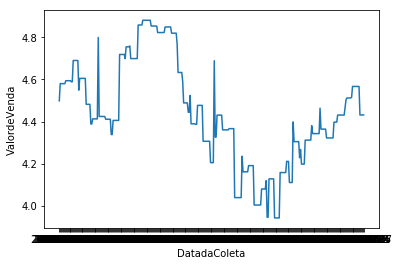

In [26]:
sns.lineplot(data=df_filled,x="DatadaColeta",y="ValordeVenda")